# New Section

CUỐI kỲ



Device: cuda


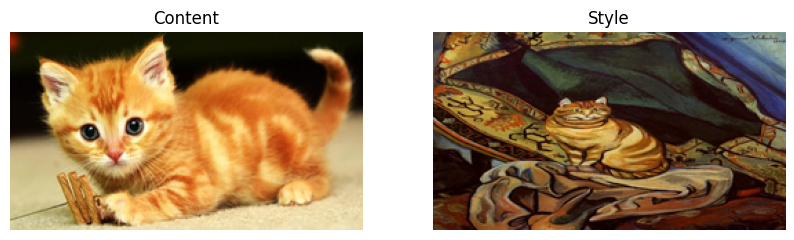

🚀 Training started...
Step 0 | Total: 343.90 | Content: 0.00 | Style: 0.03


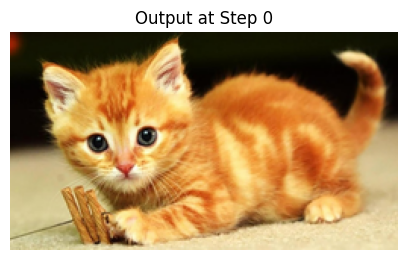

Step 50 | Total: 11.07 | Content: 6.71 | Style: 0.00


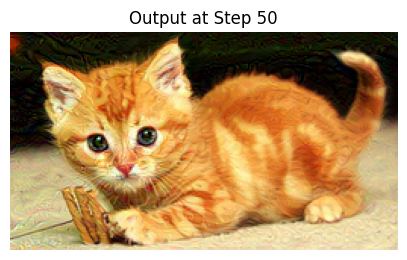

Step 100 | Total: 9.47 | Content: 5.91 | Style: 0.00


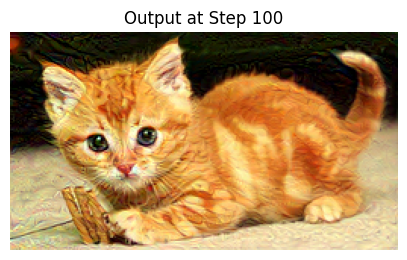

Step 150 | Total: 8.96 | Content: 5.61 | Style: 0.00


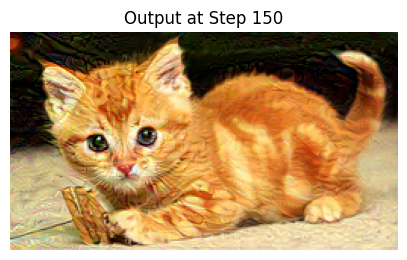

Step 200 | Total: 8.69 | Content: 5.45 | Style: 0.00


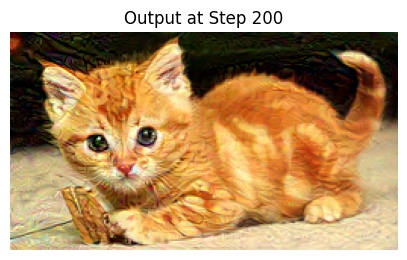

Step 250 | Total: 8.52 | Content: 5.34 | Style: 0.00


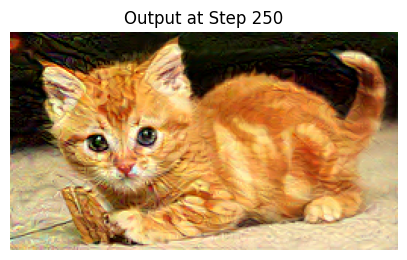

Step 300 | Total: 8.41 | Content: 5.28 | Style: 0.00


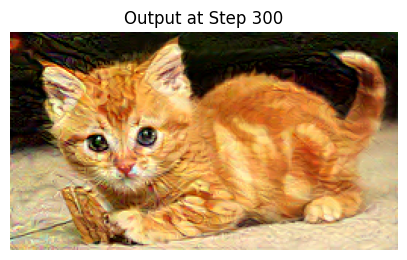

✅ Done!


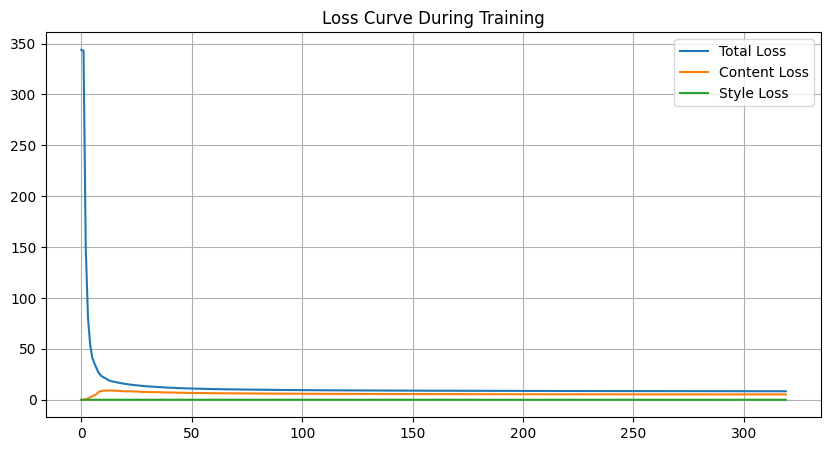

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


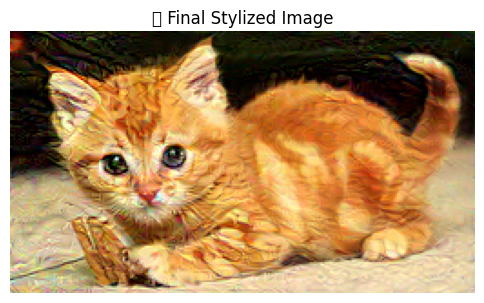

In [34]:
# ==========================================================
# 🎨 Neural Style Transfer (NST) - Hybrid Version
# Author: Nguyễn Văn Mạnh & GPT-5
# Framework: PyTorch (concept from TensorFlow original)
# ==========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np

# ----------------------------
# ⚙️ DEVICE
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# 🖼️ IMAGE LOADING & PREPROCESS
# ----------------------------
def load_image(url, max_size=512, shape=None):
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    image = Image.open(BytesIO(response.content)).convert("RGB")

    if shape:
        image = image.resize(shape, Image.LANCZOS)
    else:
        size = min(max(image.size), max_size)
        image.thumbnail((size, size), Image.LANCZOS)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    image = torch.clamp(image, 0, 1)
    return transforms.ToPILImage()(image)

# ----------------------------
# 🔢 GRAM MATRIX
# ----------------------------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b, c, h * w)
    gram = torch.bmm(tensor, tensor.transpose(1, 2))
    return gram / (c * h * w)

# ----------------------------
# 🧠 FEATURE EXTRACTOR
# ----------------------------
class VGGFeatures(nn.Module):
    def __init__(self, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.vgg = nn.Sequential(*list(vgg.children())[:29]).to(device).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_features, style_features = {}, {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# ----------------------------
# 📥 LOAD IMAGES
# ----------------------------
content_url = "https://hnm.1cdn.vn/2023/01/17/hanoimoi.com.vn-uploads-images-tuandiep-2023-01-17-_meo_vang3.jpg"
style_url   = "https://vietartview.com.vn/wp-content/uploads/2023/02/C-5.png"

content = load_image(content_url, max_size=256)
style = load_image(style_url, shape=tuple(content.shape[-2:][::-1]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(im_convert(content)); plt.title("Content"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(im_convert(style)); plt.title("Style"); plt.axis("off")
plt.show()

# ----------------------------
# ⚙️ MODEL SETUP
# ----------------------------
content_layers = ["21"]
style_layers = ["0", "5", "10", "19", "28"]

extractor = VGGFeatures(content_layers, style_layers)
content_features, _ = extractor(content)
_, style_features = extractor(style)
style_grams = {l: gram_matrix(style_features[l]) for l in style_features}

target = content.clone().requires_grad_(True).to(device)

# ----------------------------
# 🧮 LOSS SETUP
# ----------------------------
alpha = 1
beta = 1e4
optimizer = optim.LBFGS([target])
steps = 300
run = [0]

total_loss_hist, c_loss_hist, s_loss_hist = [], [], []

print("🚀 Training started...")

while run[0] <= steps:
    def closure():
        optimizer.zero_grad()
        t_content, t_style = extractor(target)
        c_loss = torch.mean((t_content["21"] - content_features["21"]) ** 2)

        s_loss = 0
        for l in style_layers:
            g_t = gram_matrix(t_style[l])
            g_s = style_grams[l]
            s_loss += torch.mean((g_t - g_s) ** 2)

        loss = alpha * c_loss + beta * s_loss
        loss.backward()

        total_loss_hist.append(loss.item())
        c_loss_hist.append(c_loss.item())
        s_loss_hist.append(s_loss.item())

        if run[0] % 50 == 0:
            print(f"Step {run[0]} | Total: {loss.item():.2f} | Content: {c_loss.item():.2f} | Style: {s_loss.item():.2f}")
            plt.figure(figsize=(5,5))
            plt.imshow(im_convert(target))
            plt.axis("off")
            plt.title(f"Output at Step {run[0]}")
            plt.show()

        run[0] += 1
        return loss

    optimizer.step(closure)

print("✅ Done!")

# ----------------------------
# 📊 VISUALIZATION
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(total_loss_hist, label="Total Loss")
plt.plot(c_loss_hist, label="Content Loss")
plt.plot(s_loss_hist, label="Style Loss")
plt.legend(); plt.grid(True)
plt.title("Loss Curve During Training")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(im_convert(target))
plt.title("🎨 Final Stylized Image")
plt.axis("off")
plt.show()


🎨 Bắt đầu huấn luyện chuyển phong cách...
Epoch 1, Step 0: Total=220710800.00, Style=22071080960.00, Content=0.00
Epoch 1, Step 20: Total=8924495.00, Style=688439232.00, Content=2040.10
Epoch 1, Step 40: Total=4352751.00, Style=274446176.00, Content=1608.29
Epoch 1, Step 60: Total=3107745.00, Style=177871648.00, Content=1329.03
Epoch 1, Step 80: Total=2558922.50, Style=140192384.00, Content=1157.00
Epoch 2, Step 0: Total=2244462.50, Style=119555200.00, Content=1048.91
Epoch 2, Step 20: Total=2033186.62, Style=106208344.00, Content=971.10
Epoch 2, Step 40: Total=1877111.50, Style=96749200.00, Content=909.62
Epoch 2, Step 60: Total=1755499.50, Style=89496760.00, Content=860.53
Epoch 2, Step 80: Total=1657622.50, Style=83780048.00, Content=819.82
Epoch 3, Step 0: Total=1577727.25, Style=79209616.00, Content=785.63
Epoch 3, Step 20: Total=1623187.88, Style=86075656.00, Content=762.43
Epoch 3, Step 40: Total=1466581.38, Style=72998752.00, Content=736.59
Epoch 3, Step 60: Total=1409010.12, S

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


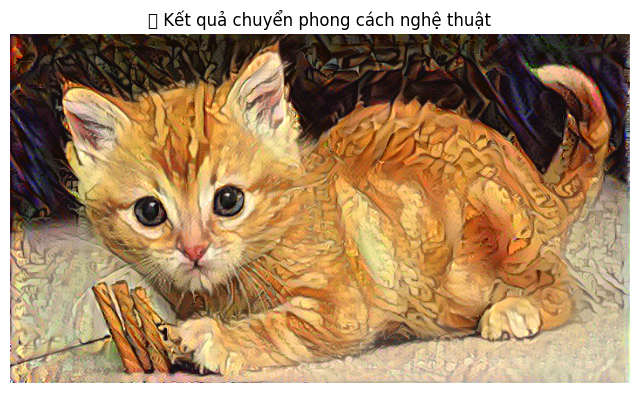

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image
import numpy as np
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

# ============ CONFIG ============
content_url = "https://hnm.1cdn.vn/2023/01/17/hanoimoi.com.vn-uploads-images-tuandiep-2023-01-17-_meo_vang3.jpg"
style_url = "https://vietartview.com.vn/wp-content/uploads/2023/02/C-5.png"

content_weight = 1e3
style_weight = 1e-2
img_height = 400

# ============ PREPROCESS ============
def load_and_process_img(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    response.raise_for_status()
    img = Image.open(io.BytesIO(response.content)).convert("RGB")

    h = img_height
    w = int(img.width * h / img.height)
    img = img.resize((w, h))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

content_img = load_and_process_img(content_url)
style_img = load_and_process_img(style_url)

# ============ MODEL ============
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = [
        'block1_conv1', 'block2_conv1',
        'block3_conv1', 'block4_conv1', 'block5_conv1'
    ]
    output_layers = style_layers + content_layers
    outputs = [vgg.get_layer(name).output for name in output_layers]
    return Model(vgg.input, outputs), style_layers, content_layers

model, style_layers, content_layers = get_model()

# ============ FEATURE EXTRACTION ============
def get_feature_representations(model, content_tensor, style_tensor):
    content_outputs = model(content_tensor)
    style_outputs = model(style_tensor)

    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]
    return style_features, content_features

style_features, content_features = get_feature_representations(model, content_img, style_img)

# ============ LOSS FUNCTIONS ============
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(style_layers))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        gram_comb_style = gram_matrix(comb_style)
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_comb_style - target_style))

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean(tf.square(comb_content - target_content))

    loss = style_weight * style_score + content_weight * content_score
    return loss, style_score, content_score

# ============ OPTIMIZATION ============
opt = tf.keras.optimizers.Adam(learning_rate=5.0)
init_image = tf.Variable(content_img, dtype=tf.float32)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

@tf.function()
def train_step(init_image):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(model, (style_weight, content_weight),
                                init_image, gram_style_features, content_features)
    loss = all_loss[0]
    grads = tape.gradient(loss, init_image)
    opt.apply_gradients([(grads, init_image)])
    init_image.assign(tf.clip_by_value(init_image, -103.939, 151.061))
    return all_loss

# ============ TRAINING ============
epochs = 5
steps_per_epoch = 100

print("🎨 Bắt đầu huấn luyện chuyển phong cách...")
for n in range(epochs):
    for m in range(steps_per_epoch):
        loss, s_loss, c_loss = train_step(init_image)
        if m % 20 == 0:
            print(f"Epoch {n+1}, Step {m}: Total={loss.numpy():.2f}, Style={s_loss.numpy():.2f}, Content={c_loss.numpy():.2f}")

# ============ HIỂN THỊ ẢNH ============
best_img = deprocess_img(init_image.numpy())
plt.figure(figsize=(8,8))
plt.imshow(best_img)
plt.axis('off')
plt.title("✨ Kết quả chuyển phong cách nghệ thuật")
plt.show()
